# Loan default prediction using neural networks

## Importing the libraries and dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('loan_data.csv')
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


We have totally 13 features in the dataset and we need to predict not.fully.paid

In [ ]:
df.isna().sum() #Checking for missing values

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

No nulls detected in th dataset

## EDA

Let's start with looking at the feature

<Axes: xlabel='not.fully.paid'>

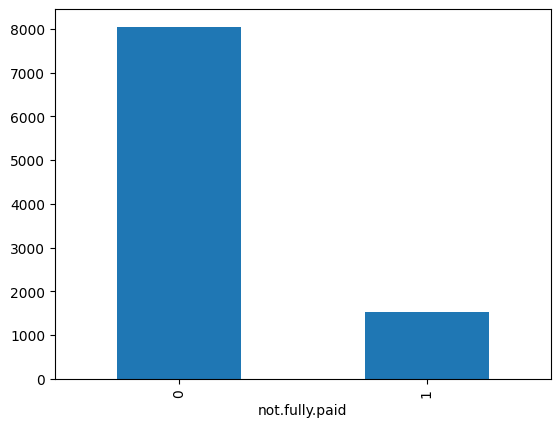

In [ ]:
df['not.fully.paid'].value_counts().plot(kind='bar')

Although the data is imbalanced with ~8000 samples representing the majority class and ~1500 samples representing minority class, there is sufficient data for the minority class. So no oversampling/undersampling is performed

We attempt to use class weights to see if that can give better results

### Checking for correlations

We check the code for correlations specifically for the columns where correlation whose values are greater that 0.5. If we find such pairs of features, we can drop one of the columns. For correlation < 0.5, the value is changed to zero. This makes the visualization of heatplot easier.

<Axes: >

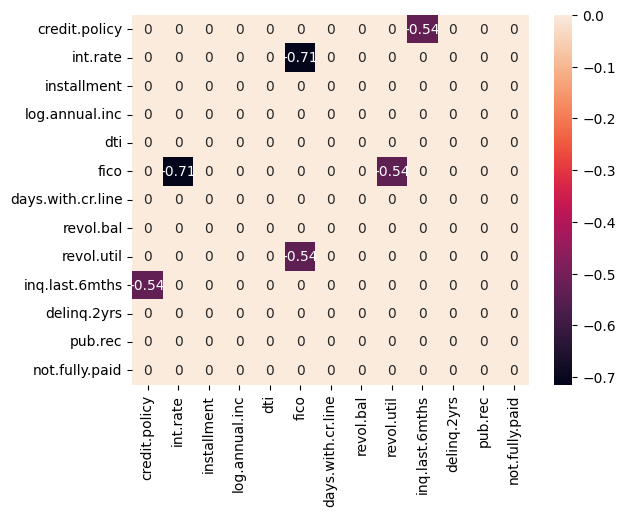

In [ ]:
# The code uses nested for loops to check for correlation values whose magnitude is greater that 0.5. If the correlation is less than this value, then the value is changed to zero.
# This helps better visualization of features with high correlation.

df_corr=df.corr(numeric_only=True)
for j in range(0,len(df_corr.columns)):
  for i in range(0,df_corr.shape[0]):
    if abs(df_corr[df_corr.columns[j]][i]) < 0.5 or i==j:
      df_corr[df_corr.columns[j]][i] = 0
sns.heatmap(df_corr, annot=True)

The highest correlation found in the dataset is between interest rate and fico and the value is 0.71. This is the pair that has highest correlation and hence we going to drop interest rate column.

### Numerical Feature analysis using boxplots

Please note that the y-limits have been changed to best visualize the IQR and the mean in some features

(0.0, 50000.0)

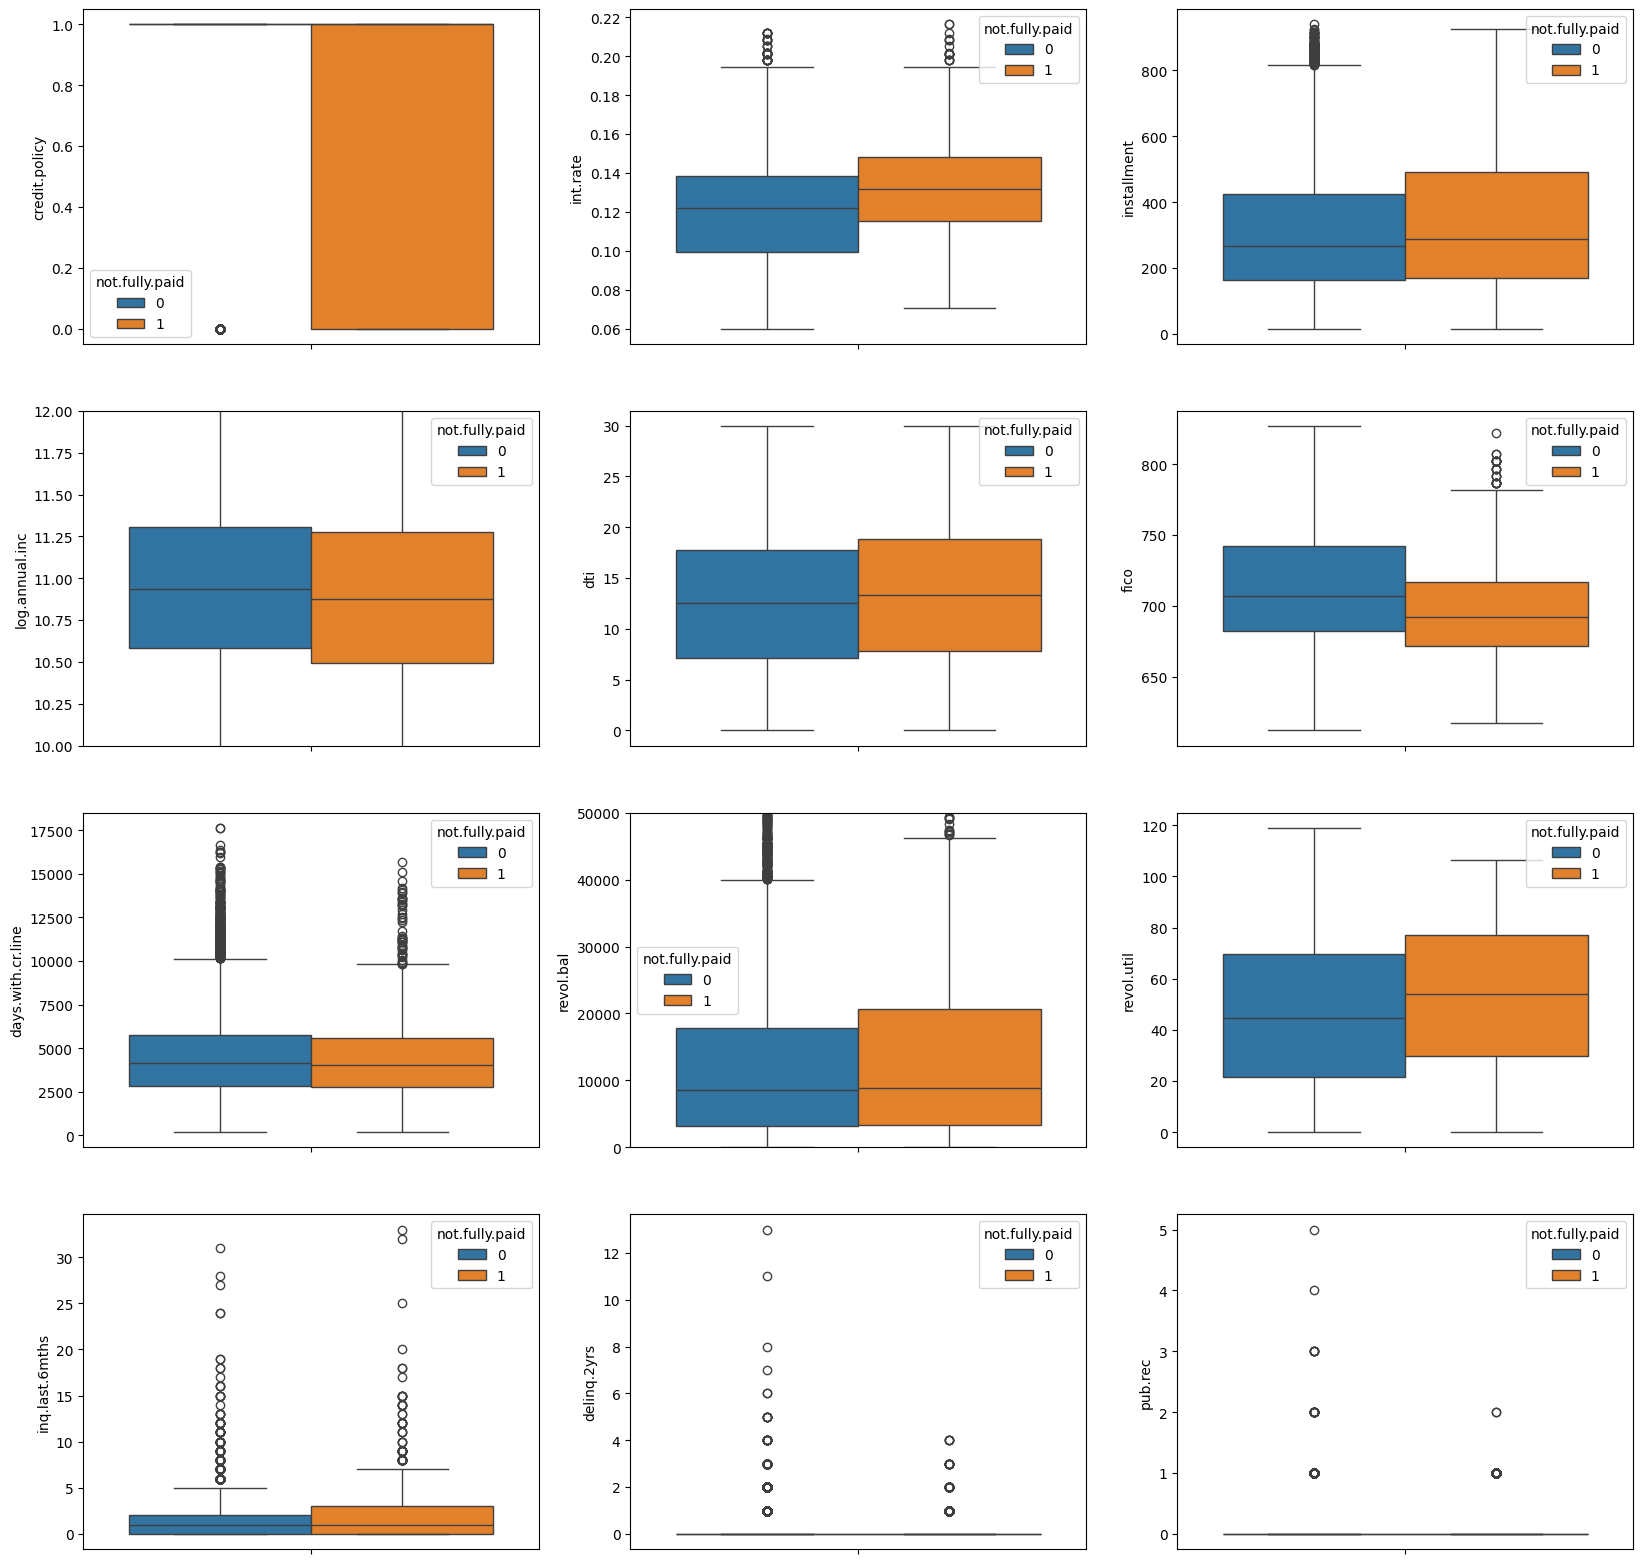

In [ ]:
df_numeric=df.select_dtypes(include=np.number)
plt.figure(figsize=(20,20))
pltref=[]
for i in range(12):
  pltref.append(plt.subplot(4,3,i+1))
  sns.boxplot(df_numeric, y=df_numeric.columns[i],hue='not.fully.paid')
pltref[3].set_ylim([10,12])
pltref[7].set_ylim([0,5e4])

The following factors can increase the risk of non-payment as seen from the box plots and the mean table below.

1. Higher interest rate
2. Higher installment
3. Lower fico score
4. Lower days with credit line
5. Higher Revolving Balance
6. Higher Inquiries

In [ ]:
df_mean = pd.concat([df_numeric[df['not.fully.paid']==0].mean(),df_numeric[df['not.fully.paid']==1].mean()],axis=1)
df_mean.columns=['Fully Paid','Not Fully Paid']
df_mean

,Fully Paid,Not Fully Paid
credit.policy,0.832318,0.661448
int.rate,0.120770,0.132452
installment,314.574123,342.785114
log.annual.inc,10.941091,10.885023
dti,12.494413,13.195838
fico,713.326911,697.828441
days.with.cr.line,4592.632624,4393.541259
revol.bal,16122.724425,21066.293542
revol.util,45.759608,52.255075
inq.last.6mths,1.433934,2.330724


### Categorical feature analysis

<Axes: xlabel='purpose', ylabel='count'>

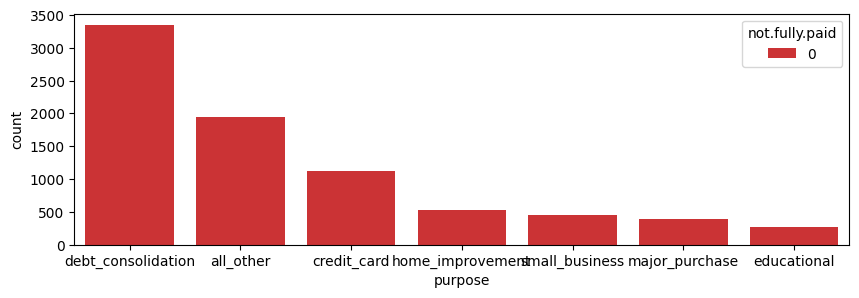

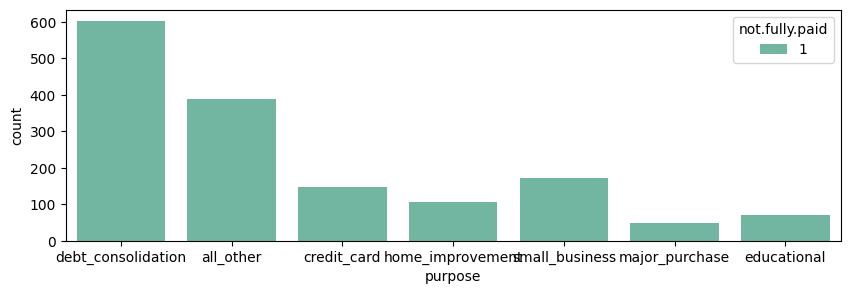

In [ ]:
plt.figure(figsize=(10,3))
sns.countplot(x='purpose', hue='not.fully.paid', data=df[df['not.fully.paid']==0], order=df['purpose'].value_counts().index,palette='Set1')
plt.figure(figsize=(10,3))
sns.countplot(x='purpose', hue='not.fully.paid', data=df[df['not.fully.paid']==1], order=df['purpose'].value_counts().index,palette='Set2')

The overall value counts for the different categories remains the same for both output classes

## Data Transformation and model training

In [ ]:
# Using one hot encoding for purpose

df.drop('int.rate', axis=1, inplace=True)
df_ml = pd.get_dummies(df, columns=['purpose'], dtype=int)
df_ml.head()

,credit.policy,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0


In [ ]:
#Separating the target and features

X = df_ml.drop('not.fully.paid', axis=1).values
y = df_ml['not.fully.paid'].values

In [ ]:
#Creating the test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Class weights calculation has been performed to see if using class weights can improve the neural network learning

In [ ]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.5954305253341623, 1: 3.1197068403908794}

Neural network creating usng Sequential method with the use of dropout layer for regularization

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               2432      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10753 (42.00 KB)
Trainable params: 10753 (42.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Model training with the use of class weights

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history1 = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/50
192/192 [==============================] - 2s 4ms/step - loss: 0.6794 - accuracy: 0.5928 - val_loss: 0.6449 - val_accuracy: 0.6621
Epoch 2/50
192/192 [==============================] - 1s 3ms/step - loss: 0.6525 - accuracy: 0.6198 - val_loss: 0.6307 - val_accuracy: 0.6667
Epoch 3/50
192/192 [==============================] - 1s 3ms/step - loss: 0.6559 - accuracy: 0.6032 - val_loss: 0.6648 - val_accuracy: 0.5962
Epoch 4/50
192/192 [==============================] - 1s 3ms/step - loss: 0.6498 - accuracy: 0.6228 - val_loss: 0.6684 - val_accuracy: 0.5734
Epoch 5/50
192/192 [==============================] - 1s 3ms/step - loss: 0.6515 - accuracy: 0.6066 - val_loss: 0.6446 - val_accuracy: 0.6047
Epoch 6/50
192/192 [==============================] - 1s 3ms/step - loss: 0.6413 - accuracy: 0.6066 - val_loss: 0.6226 - val_accuracy: 0.6562
Epoch 7/50
192/192 [==============================] - 1s 3ms/step - loss: 0.6431 - accuracy: 0.6167 - val_loss: 0.6442 - val_accuracy: 0.6164
Epoch 

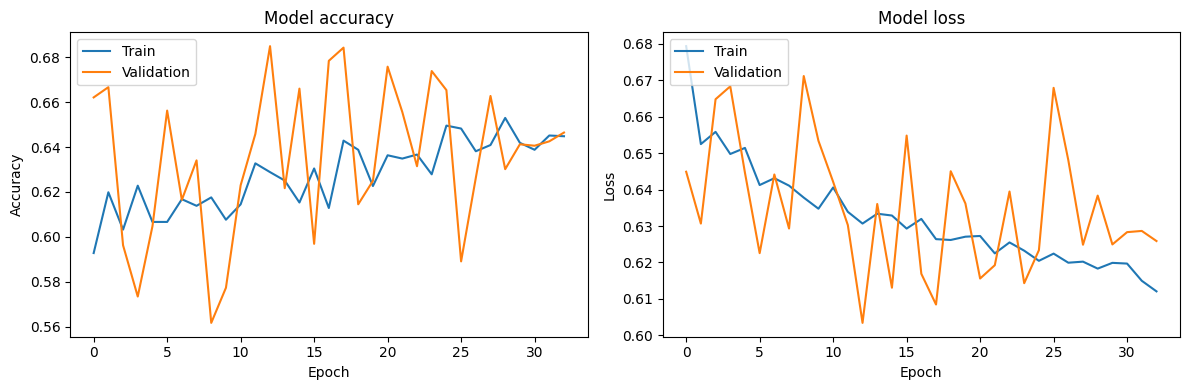

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

60/60 [==============================] - 0s 2ms/step - loss: 0.5987 - accuracy: 0.6795
Test Loss: 0.5986566543579102
Test Accuracy: 0.6795406937599182


### Model training without the use of class weights

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history2 = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
 #   class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/50
192/192 [==============================] - 1s 3ms/step - loss: 0.4307 - accuracy: 0.8292 - val_loss: 0.4193 - val_accuracy: 0.8421
Epoch 2/50
192/192 [==============================] - 1s 3ms/step - loss: 0.4114 - accuracy: 0.8411 - val_loss: 0.4128 - val_accuracy: 0.8434
Epoch 3/50
192/192 [==============================] - 1s 4ms/step - loss: 0.4146 - accuracy: 0.8396 - val_loss: 0.4110 - val_accuracy: 0.8434
Epoch 4/50
192/192 [==============================] - 1s 4ms/step - loss: 0.4071 - accuracy: 0.8419 - val_loss: 0.4111 - val_accuracy: 0.8415
Epoch 5/50
192/192 [==============================] - 1s 5ms/step - loss: 0.4104 - accuracy: 0.8395 - val_loss: 0.4111 - val_accuracy: 0.8421
Epoch 6/50
192/192 [==============================] - 1s 4ms/step - loss: 0.4117 - accuracy: 0.8399 - val_loss: 0.4102 - val_accuracy: 0.8408
Epoch 7/50
192/192 [==============================] - 1s 3ms/step - loss: 0.4078 - accuracy: 0.8409 - val_loss: 0.4109 - val_accuracy: 0.8415
Epoch 

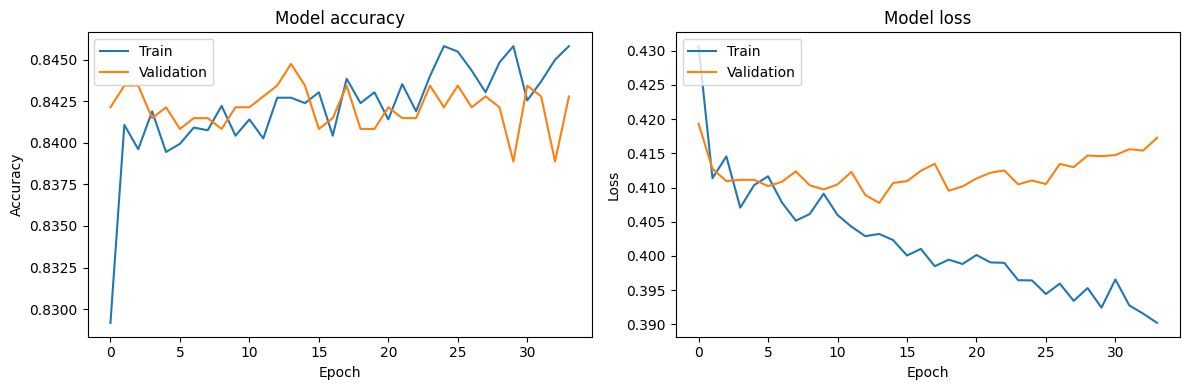

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

60/60 [==============================] - 0s 2ms/step - loss: 0.4023 - accuracy: 0.8413
Test Loss: 0.4022967219352722
Test Accuracy: 0.8413361310958862


## Summary

A neural network model has been implemented to predict the risk of payment of credit users. EDA has been performed and data relationships have been identified. Also, one feature which is redundant because of high correlation with another feature. The machine learning model was deployed with the use of dropout layer for regularization.

To account for the class imbalance, class weights parameter was used in the training process. However, results were unsatisfactory and not using class weights parameter produced better accuracy. An accuracy score of 84.1 % was achieved.